# SpatialMouse: Remove background of data

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
## Import the custom library
import os
import sys

# add xDbit toolbox path to path variable
module_path = os.path.abspath("../../")
if module_path not in sys.path:
    sys.path.append(module_path)

import xdbit_funcs as db

In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path
import seaborn as sns
import gc
import anndata

In [4]:
plt.rcParams['figure.dpi'] = 100
plt.style.use('default')

## Results until here:

### Registration
- Registration worked for most samples but not for all.
- Samples where the registration did not work as wished:
    - 37_38_A1 - Spleen
    - 37_38_A2 - Spleen
    - 37_38_C3 - Pancreas
    
### Transcriptomic quality
- The transcriptomic quality of following samples is too low:
    - 37_38_C2 - Pancreas
    - 37_38_C3 - Pancreas
    
    
### Summary

#### Substitute HQ images with Alignment images for following datasets:
    - 37_38_A1
    - 37_38_A2

#### Remove following datasets completely for further analysis:
    - 37_38_C2
    - 37_38_C3

# Load data

The data for this publication can be found in : https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE207843
<br> Note: Until publication a reviewer token is necessary to access the data.



In [9]:
# give directories with anndata files
# this is just an example and needs to be adjusted depending on where the data was downloaded to.
anndata_dirs = [
    "D:/data/37_38/anndata/",
    "D:/data/37_46/anndata/"
]

anndata_dirs = [
    "/home/hpc/johannes.wirth/data/experiments/37_38/anndata/",
    "/home/hpc/johannes.wirth/data/experiments/37_46/anndata/"
]

# get list of files
in_files = []
for d in anndata_dirs:
    in_files.extend(glob(os.path.join(d, "*h5ad")))
    
# create an output directory for the data
out_dir = "out"
Path(out_dir).mkdir(parents=True, exist_ok=True)

### Manually remove and add certain datasets

see results above

In [10]:
# remove datasets
ids_to_remove = ["37_38_A1", "37_38_A2", "37_38_C2", "37_38_C3"]
in_files = [p for p in in_files if not np.any([i in p for i in ids_to_remove])]

# add paths to aligned datasets without hq images
paths_to_add = [
    "D:/data/37_38/anndata/tmp/37_38_A1_alignimages.h5ad",
    "D:/data/37_38/anndata/tmp/37_38_A2_alignimages.h5ad"
]

paths_to_add = [
    "/home/hpc/johannes.wirth/data/experiments/37_38/anndata/tmp/37_38_A1_alignimages.h5ad",
    "/home/hpc/johannes.wirth/data/experiments/37_38/anndata/tmp/37_38_A2_alignimages.h5ad"
]

in_files = in_files + paths_to_add

## Read per well ID

In [11]:
remove_images = True
hires_only = True

adatas = {}
for f in in_files:
    # read adata
    a = sc.read(f)
    
    # fetch organ
    organ = list(a.obs['organ'].unique())
    
    if len(organ) == 1:
        organ = organ[0]
    else:
        print("More than one organ in dataset {}".format(f))
        break
    
    # fetch id
    idx = list(a.obs['id'].unique())
    
    if len(idx) == 1:
        idx = idx[0]
    else:
        print("More than one id in dataset {}".format(f))
        break
           
    if remove_images:
        db.tl.remove_images(a, hires_only=hires_only)
    
    # save datasets in dictionary
    if organ not in adatas:
        adatas[organ] = {}
    
    adatas[organ][idx] = a

## Select spots containing DAPI signal

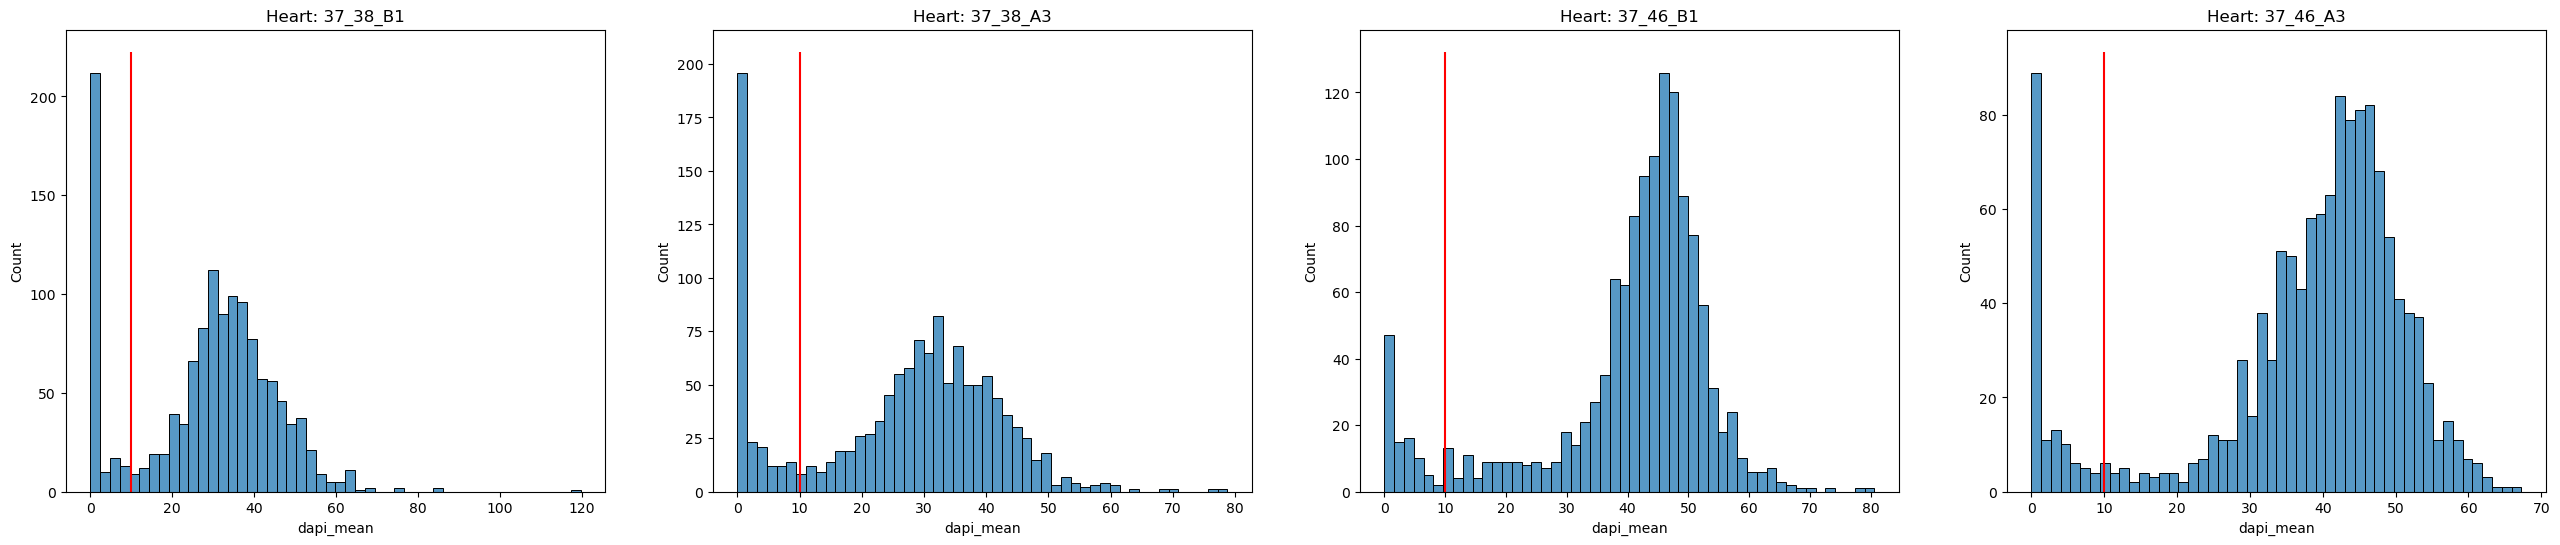

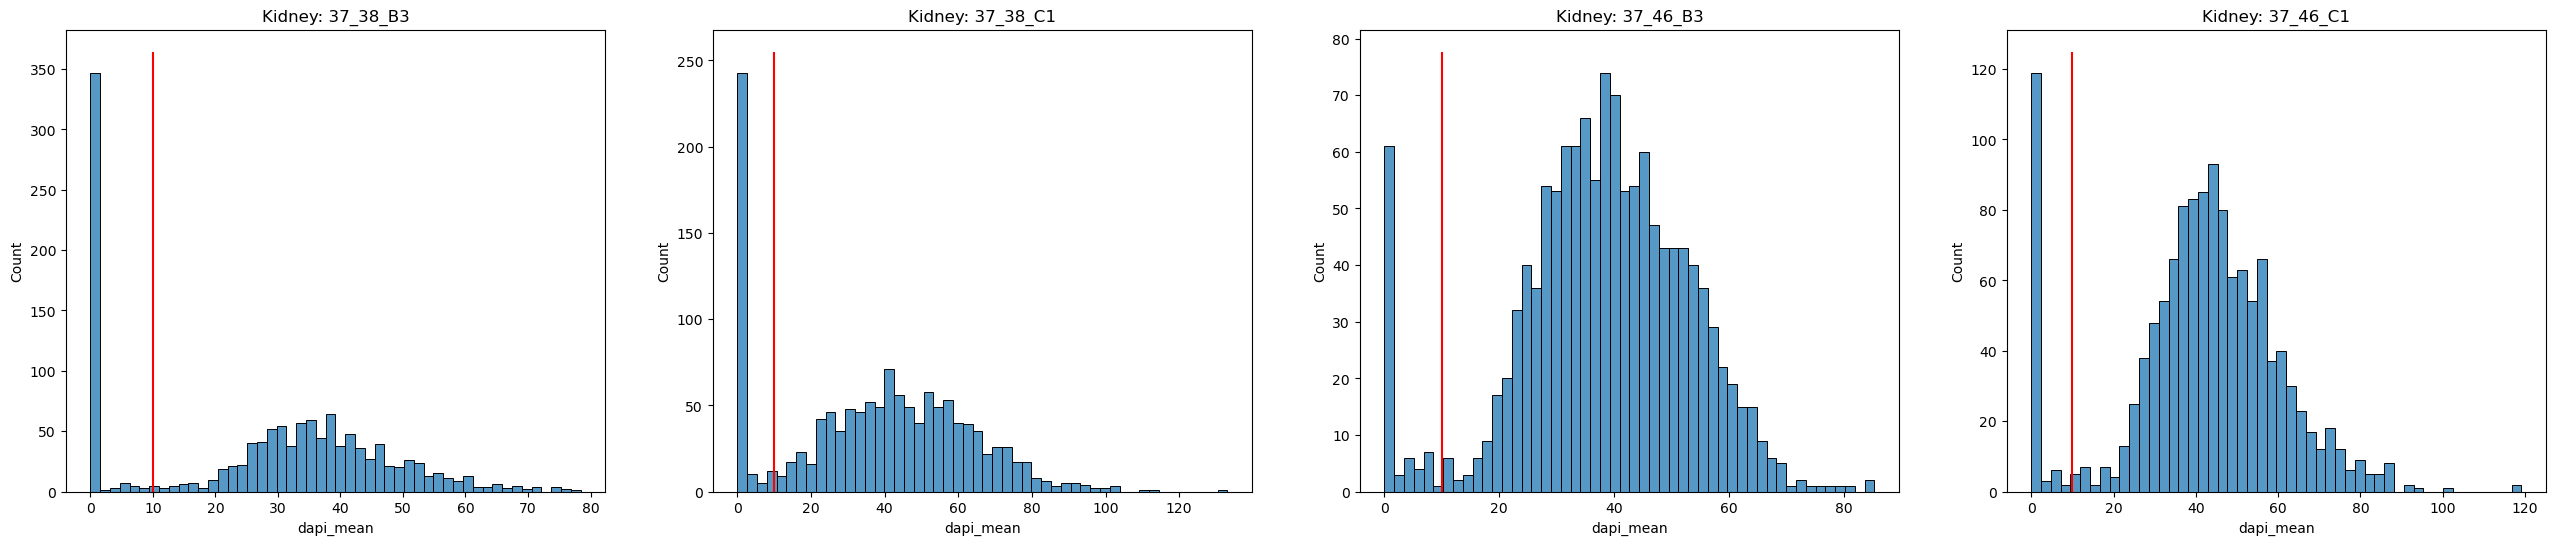

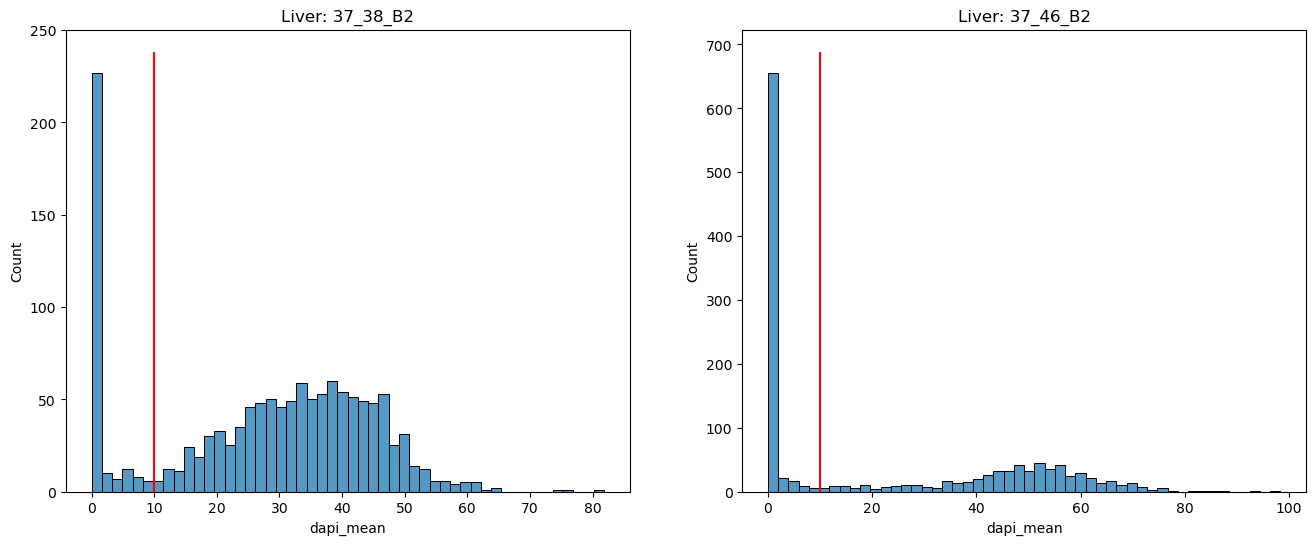

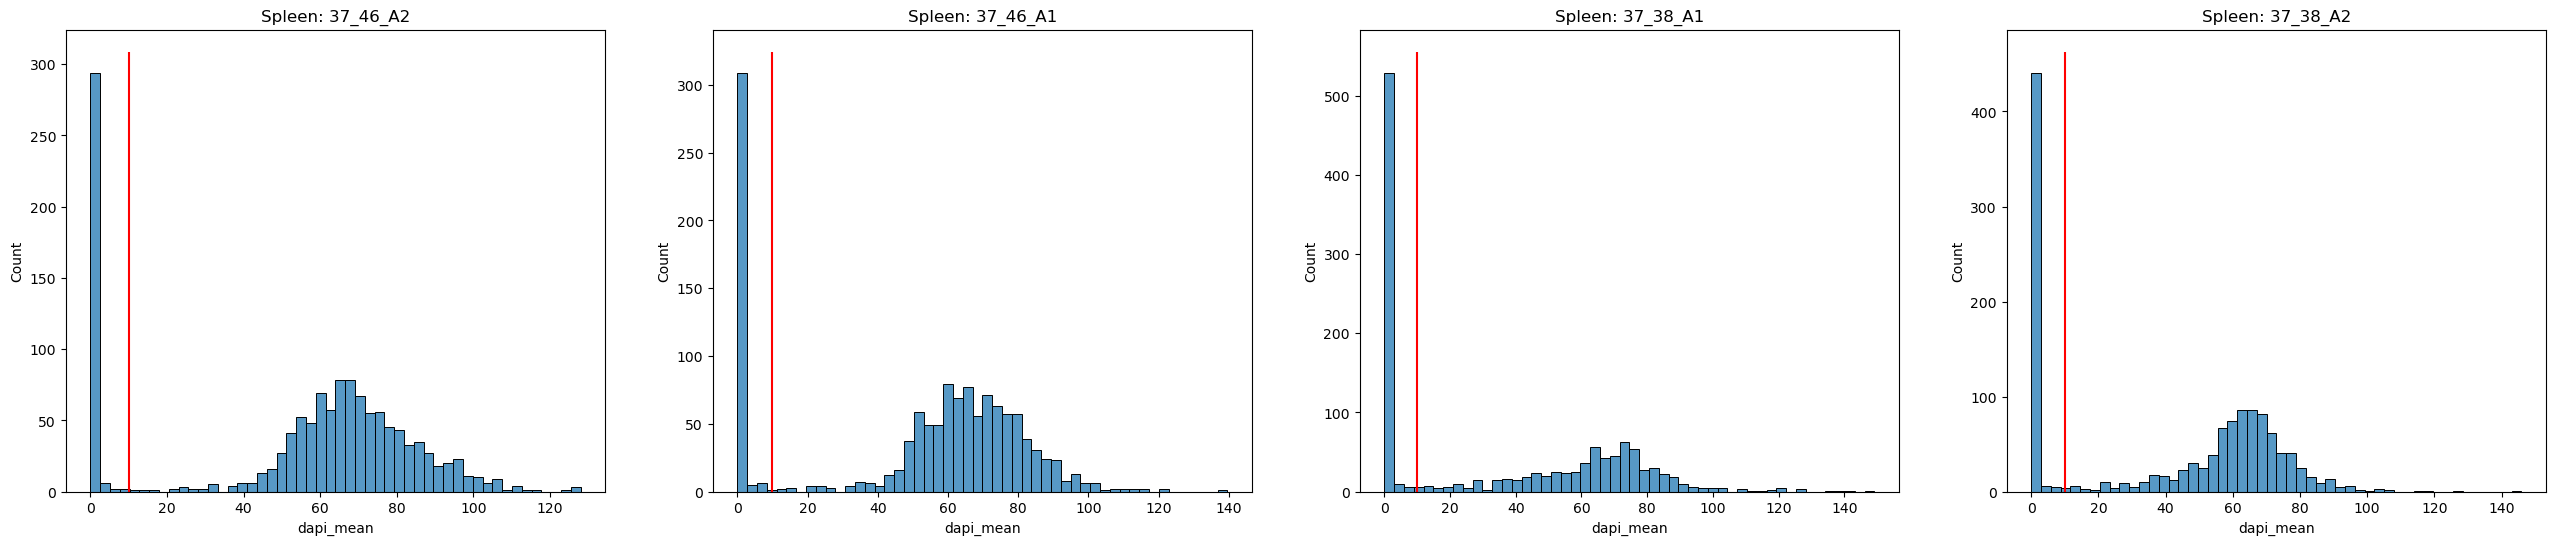

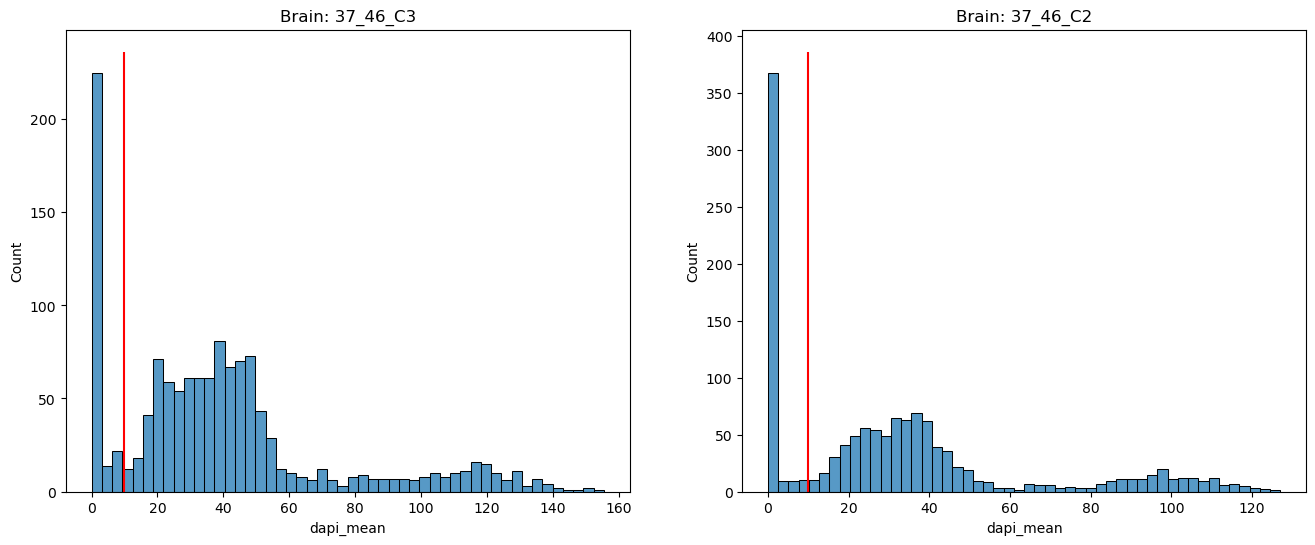

In [12]:
cat = 'dapi_mean'
nbins = 50

for organ, organdict in adatas.items():
    nrows = 1
    ncols = len(organdict)
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*8, nrows*6))
    
    for c, (idx, adata) in enumerate(organdict.items()):
        
        h = sns.histplot(data=adata.obs, x=cat, bins=nbins, ax=axs[c])
        axs[c].vlines(10, ymin=0, ymax=h.get_ylim()[1], color='r')
        axs[c].set_title("{}: {}".format(organ, idx))
    plt.show()

## Split data into background and signal

In [13]:
threshold = 10

backgrounds = {}

for organ, organdict in adatas.items():
    for idx, adata in organdict.items():
        # collect background spots
        a = adata[adata.obs['dapi_mean'] < threshold].copy()

        # remove images from background dataset to save memory
        db.tl.remove_images(a)
        
        # save background
        if organ not in backgrounds:
            backgrounds[organ] = {}
            
        backgrounds[organ][idx] = a

        # save sample spots
        adatas[organ][idx] = adata[adata.obs['dapi_mean'] >= threshold].copy()

gc.collect()

64097

## Filter genes for minimum number of spots

We only use genes that are in at least 0.5 % of the spots.

In [14]:
# set minimum fraction of spots in which the genes should be found
min_frac_spots = 0.005

for organ, organdict in adatas.items():
    for idx, adata in organdict.items():
        min_spots = int(adata.shape[0] * min_frac_spots)
        sc.pp.filter_genes(adata, min_cells=min_spots)
        
        # transfer results to background
        back = backgrounds[organ][idx]
        mask = back.var_names.isin(adata.var_names)
        backgrounds[organ][idx] = back[:, mask].copy()

# Remove background signal

## Select signal based on background noise

### Strategy
- the measurement of the counts is rather Poisson distributed than normal distributed
- we assume a poisson distribution and calculate the standard deviation based on this assumption
- The mean $\mu$, and an approximated standard deviation $\sigma$ of the poisson distribution with parameter $\lambda$ is
\begin{equation*}
\lambda = \mu \\
\sigma = \sqrt{\lambda}
\end{equation*}
- Approximation assuming normal distribution
\begin{equation*}
(1) \ N +- 1.96 * \sqrt{N} \\
(2) \ N + 1.64 * \sqrt{N} \\
with \ N = n * \mu, \\
N: total \ number \ of \ observations. \\
N = \lambda \ in \ Poisson \ distribution. \\
n: number \ of \ samples, \\
\mu: mean \ of \ observations
\end{equation*}

<center>(1) Two-sided 95 % CI</center>
<center>(2) One-sided 95 % CI</center>

- Filter out genes that are below mean + 2*SD of background assuming a Poisson distribution

In [15]:
filtered = {}
masks = {}

for organ, organdict in adatas.items():
    print("Processing {}:".format(organ))
    for idx, adata in organdict.items():
        # select background
        back = backgrounds[organ][idx]
        print("\t{}".format(idx))
        print("\t\tBefore filtering: {} genes.".format(adata.shape[1]))
        # calculate count statistics
        adata.var['mean_counts_perwell'] = adata.X.mean(axis=0)
        adata.var['sum_counts_perwell'] = adata.X.sum(axis=0)
        back.var['mean_counts_perwell'] = back.X.mean(axis=0)
        back.var['sum_counts_perwell'] = back.X.sum(axis=0)
        
        # filter out genes that are outside of the confidence interval assuming a poisson distribution of the observed background
        #nback = back.shape[0]
        #mask = np.array([s > poisson_interval(b, alpha=0.05)[1] / nback for s, b in zip(adata.var['mean_counts_perwell'], back.var['sum_counts_perwell'])])
        
        # filter out genes that are below mean + 2*SD of the background assuming a Poisson distribution where SD=sqrt(mean)
        mask = np.array([s > (b + 2*np.sqrt(b)) for s, b in zip(adata.var['mean_counts_perwell'], back.var['mean_counts_perwell'])])
        
        if organ not in filtered:
            filtered[organ] = {}
            
        if organ not in masks:
            masks[organ] = {}
            
        filtered[organ][idx] = adata[:, mask].copy()
        masks[organ][idx] = mask
        print("\t\tAfter filtering: {} genes.".format(mask.sum()))

Processing Heart:
	37_38_B1
		Before filtering: 20880 genes.
		After filtering: 4880 genes.
	37_38_A3
		Before filtering: 20104 genes.
		After filtering: 4158 genes.
	37_46_B1
		Before filtering: 19897 genes.
		After filtering: 4147 genes.
	37_46_A3
		Before filtering: 18972 genes.
		After filtering: 4813 genes.
Processing Kidney:
	37_38_B3
		Before filtering: 26045 genes.
		After filtering: 12265 genes.
	37_38_C1
		Before filtering: 25723 genes.
		After filtering: 12641 genes.
	37_46_B3
		Before filtering: 21313 genes.
		After filtering: 9727 genes.
	37_46_C1
		Before filtering: 22525 genes.
		After filtering: 12915 genes.
Processing Liver:
	37_38_B2
		Before filtering: 22802 genes.
		After filtering: 8821 genes.
	37_46_B2
		Before filtering: 21950 genes.
		After filtering: 7644 genes.
Processing Spleen:
	37_46_A2
		Before filtering: 24283 genes.
		After filtering: 15218 genes.
	37_46_A1
		Before filtering: 25730 genes.
		After filtering: 14435 genes.
	37_38_A1
		Before filtering: 310

## Merge datasets per organ

Per organ we keep all genes that remained after filtering in at least one sample of the respective organ.

In [19]:
genes_per_organ = {}
for organ in adatas:
    # get list of genes to keep for each section for this organ
    genelists = [list(adatas[organ][idx].var_names[masks[organ][idx]]) for idx in adatas[organ]]
    # flatten list of lists
    genes_to_keep = np.unique([y for x in genelists for y in x])
    
    genes_per_organ[organ] = genes_to_keep

In [22]:
perOrgan = {}
perOrgan_raw = {}
for organ, adatadict in adatas.items():
    a = anndata.concat(list(adatadict.values()), uns_merge='unique')
    mask = a.var_names.isin(genes_per_organ[organ])
    af = a[:, mask].copy()
    perOrgan[organ] = af
    perOrgan_raw[organ] = a

In [23]:
perOrgan

{'Heart': AnnData object with n_obs × n_vars = 4412 × 6049
     obs: 'array_row', 'array_col', 'um_row', 'um_col', 'id', 'pixel_row', 'pixel_col', 'dapi_mean', 'experiment_id', 'age', 'organ', 'age_months', 'mouse_id', 'exp_date'
     uns: 'registered', 'spatial'
     obsm: 'spatial',
 'Kidney': AnnData object with n_obs × n_vars = 4329 × 15058
     obs: 'array_row', 'array_col', 'um_row', 'um_col', 'id', 'pixel_row', 'pixel_col', 'dapi_mean', 'experiment_id', 'age', 'organ', 'age_months', 'mouse_id', 'exp_date'
     uns: 'registered', 'spatial'
     obsm: 'spatial',
 'Liver': AnnData object with n_obs × n_vars = 1612 × 9147
     obs: 'array_row', 'array_col', 'um_row', 'um_col', 'id', 'pixel_row', 'pixel_col', 'dapi_mean', 'experiment_id', 'age', 'organ', 'age_months', 'mouse_id', 'exp_date'
     uns: 'registered', 'spatial'
     obsm: 'spatial',
 'Spleen': AnnData object with n_obs × n_vars = 3440 × 17664
     obs: 'array_row', 'array_col', 'um_row', 'um_col', 'id', 'pixel_row', 'pix

In [24]:
perOrgan_raw

{'Heart': AnnData object with n_obs × n_vars = 4412 × 17401
     obs: 'array_row', 'array_col', 'um_row', 'um_col', 'id', 'pixel_row', 'pixel_col', 'dapi_mean', 'experiment_id', 'age', 'organ', 'age_months', 'mouse_id', 'exp_date'
     uns: 'registered', 'spatial'
     obsm: 'spatial',
 'Kidney': AnnData object with n_obs × n_vars = 4329 × 20260
     obs: 'array_row', 'array_col', 'um_row', 'um_col', 'id', 'pixel_row', 'pixel_col', 'dapi_mean', 'experiment_id', 'age', 'organ', 'age_months', 'mouse_id', 'exp_date'
     uns: 'registered', 'spatial'
     obsm: 'spatial',
 'Liver': AnnData object with n_obs × n_vars = 1612 × 20123
     obs: 'array_row', 'array_col', 'um_row', 'um_col', 'id', 'pixel_row', 'pixel_col', 'dapi_mean', 'experiment_id', 'age', 'organ', 'age_months', 'mouse_id', 'exp_date'
     uns: 'registered', 'spatial'
     obsm: 'spatial',
 'Spleen': AnnData object with n_obs × n_vars = 3440 × 22884
     obs: 'array_row', 'array_col', 'um_row', 'um_col', 'id', 'pixel_row', 'p

## Statistics on spillover

We use in the following the HOMER database for organ-specific genes to check for spillovers:
http://discovery.informatics.uab.edu/HOMER/index.html

In [25]:
homer = pd.read_csv("../source_data/dbest_tisged_hpa_HMID.txt", sep="\t")
idtogene = pd.read_csv("../source_data/GeneHMIDtoGeneSymbol.txt", sep="\t").set_index("HOMERID")
#idtogene_dict = {k: v for k, v in zip(idtogene["HOMERID"], idtogene["GENENAME"])}
# assign human-readable names and convert to murine type genes
homer["gene"] = [str(idtogene.loc[idx, "GENENAME"]).title() for idx in homer["Gene HMID"]]

# select organs from our dataset and sort values per organ
homer = pd.concat({organ: homer.query('organ == "{}"'.format(organ.lower())).sort_values(["pvalue", "zscore"]) for organ in adatas.keys()})

In [29]:
homer

Gene HMID  organ  pvalue  zscore  source    gene
Heart 6122   HM00194  heart     0.0    5.07   dbEST    Ldb3
      919    HM00279  heart     0.0    5.59   dbEST     Pln
      4147   HM00319  heart     0.0    5.74   dbEST     Afp
      194    HM00248  heart     0.0    6.82   dbEST   Actc1
      4476   HM00313  heart     0.0    7.00   dbEST   Tnnt2
...              ...    ...     ...     ...     ...     ...
Brain 6956   HM06951  brain     1.0     NaN  TiSGeD   Reg1P
      1681   HM06584  brain     NaN     NaN     HPA     Cnp
      2524   HM06400  brain     NaN     NaN     HPA  Hcrtr1
      3944   HM06594  brain     NaN     NaN     HPA  Cdkn2A
      7678   HM05036  brain     NaN     NaN     HPA    Pklr

[1427 rows x 6 columns]

In [51]:
data = [perOrgan_raw, perOrgan] # datasets before and after filtering
names = ["raw", "clean"]
topn = 100

spillall = {}
for i, d in enumerate(data):
    spill = {}
    for organ in homer.index.unique(level=0):
        # get top specific genes for this organ
        #topgenes = homer.xs(organ).head(topn)['gene'].values
        topgenes = homer.xs(organ)['gene'].values

        # select only genes that are in the dataset of the source organ
        topgenes = [gene for gene in topgenes if gene in d[organ].var_names]
        topgenes = topgenes[:topn]

        spilldict = {}
        for o, a in d.items():

            ingenes = [gene in a.var_names for gene in topgenes]
            pct = np.sum(ingenes) / len(ingenes) * 100
            spilldict[o] = pct
        
        spill[organ] = spilldict

    spill = pd.DataFrame(spill)
    spill.index.name = 'source'
    spill.columns.name = 'target'
    
    spillall[names[i]] = spill

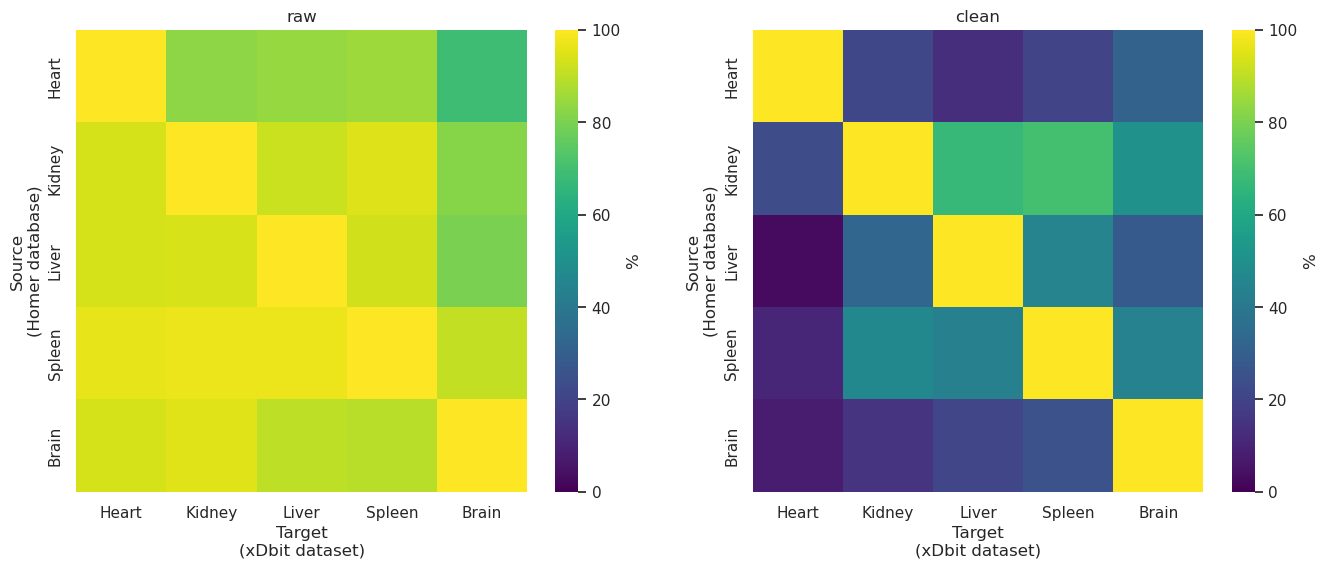

In [71]:
ncols = len(spillall)

fig, axs = plt.subplots(1, ncols, figsize=(8 * ncols, 6))

if ncols == 1:
    axs = [axs]

for i, (name, df) in enumerate(spillall.items()):
    sns.set_theme(font_scale=1)
    sns.heatmap(df, cmap='viridis', ax=axs[i], 
                cbar_kws={'label': '%'},
                vmin=0, vmax=100
               )
    axs[i].set_title(name)
    axs[i].set_ylabel("Source\n(Homer database)")
    axs[i].set_xlabel("Target\n(xDbit dataset)")
    
#fig.tight_layout()
    
plt.savefig("figures/clean_dataset/heatmap_spillover_homer.pdf")
plt.show()

# Count statistics

## Before and after background removal

In [55]:
adatasets = [perOrgan_raw, perOrgan]

for d in adatasets:
    for organ, adata in d.items():
        adata.var['mt'] = adata.var_names.str.contains('MT-', case=False)  # annotate the group of mitochondrial genes as 'mt'
        sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [56]:
cats = ["total_counts", "n_genes_by_counts", "pct_counts_mt"]
adatasets = [perOrgan_raw, perOrgan]
names = ["raw", "clean"]

datasets = {}
for i, adataset in enumerate(adatasets):
    datas = {}
    for cat in cats:
        data = pd.DataFrame({
            organ: adataset[organ].obs[cat] for organ in adataset.keys()
        }).melt(var_name='organ', value_name=cat, ignore_index=False).dropna()
        datas[cat] = data

    data = pd.concat(datas, axis=1)
    data.columns = data.columns.droplevel()
    data = data.loc[:, ~data.columns.duplicated()]
    
    datasets[names[i]] = data

raw


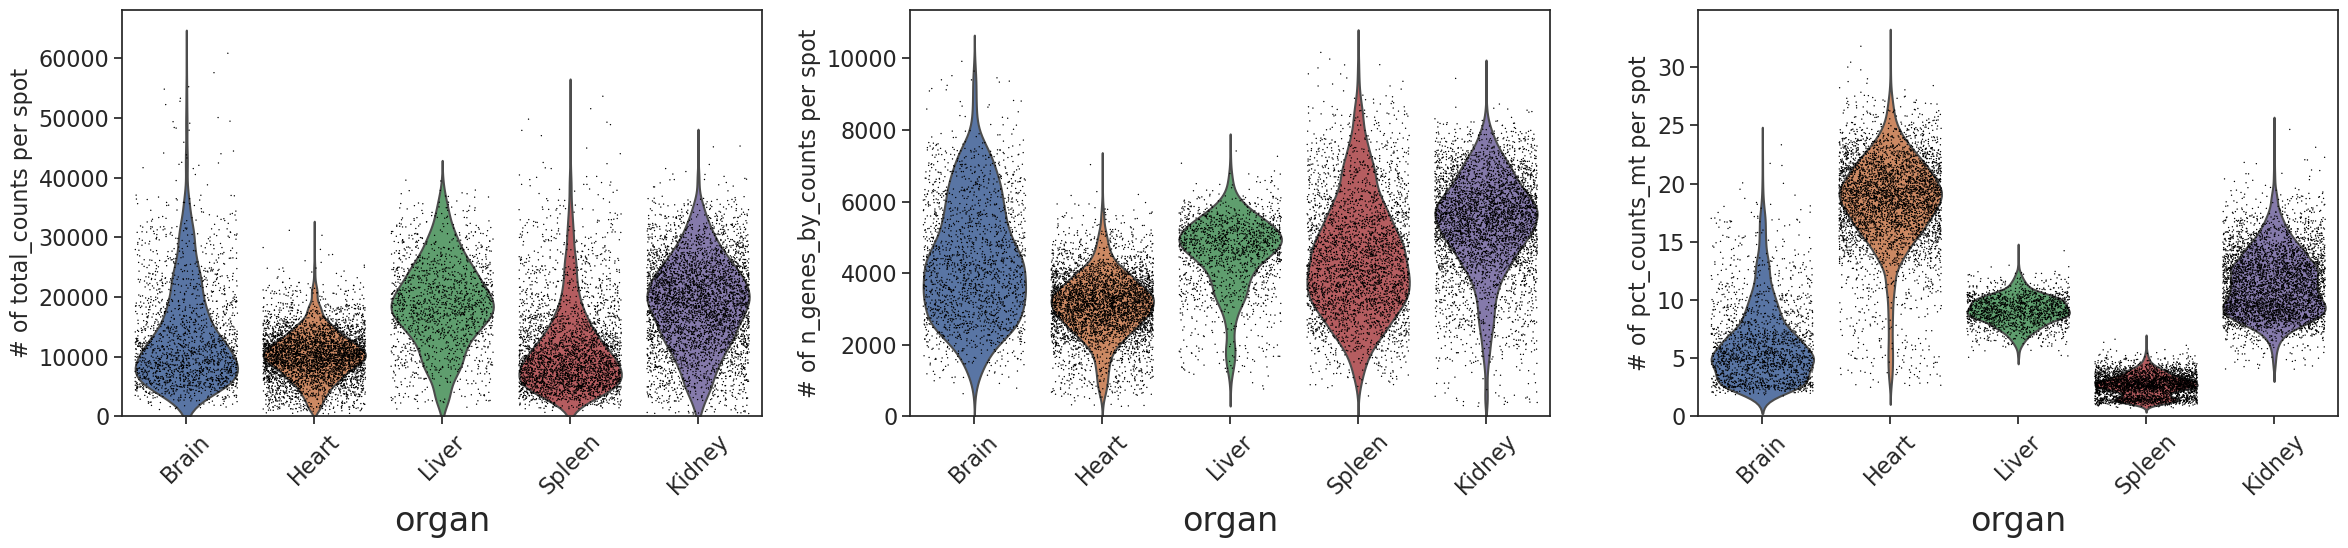

clean


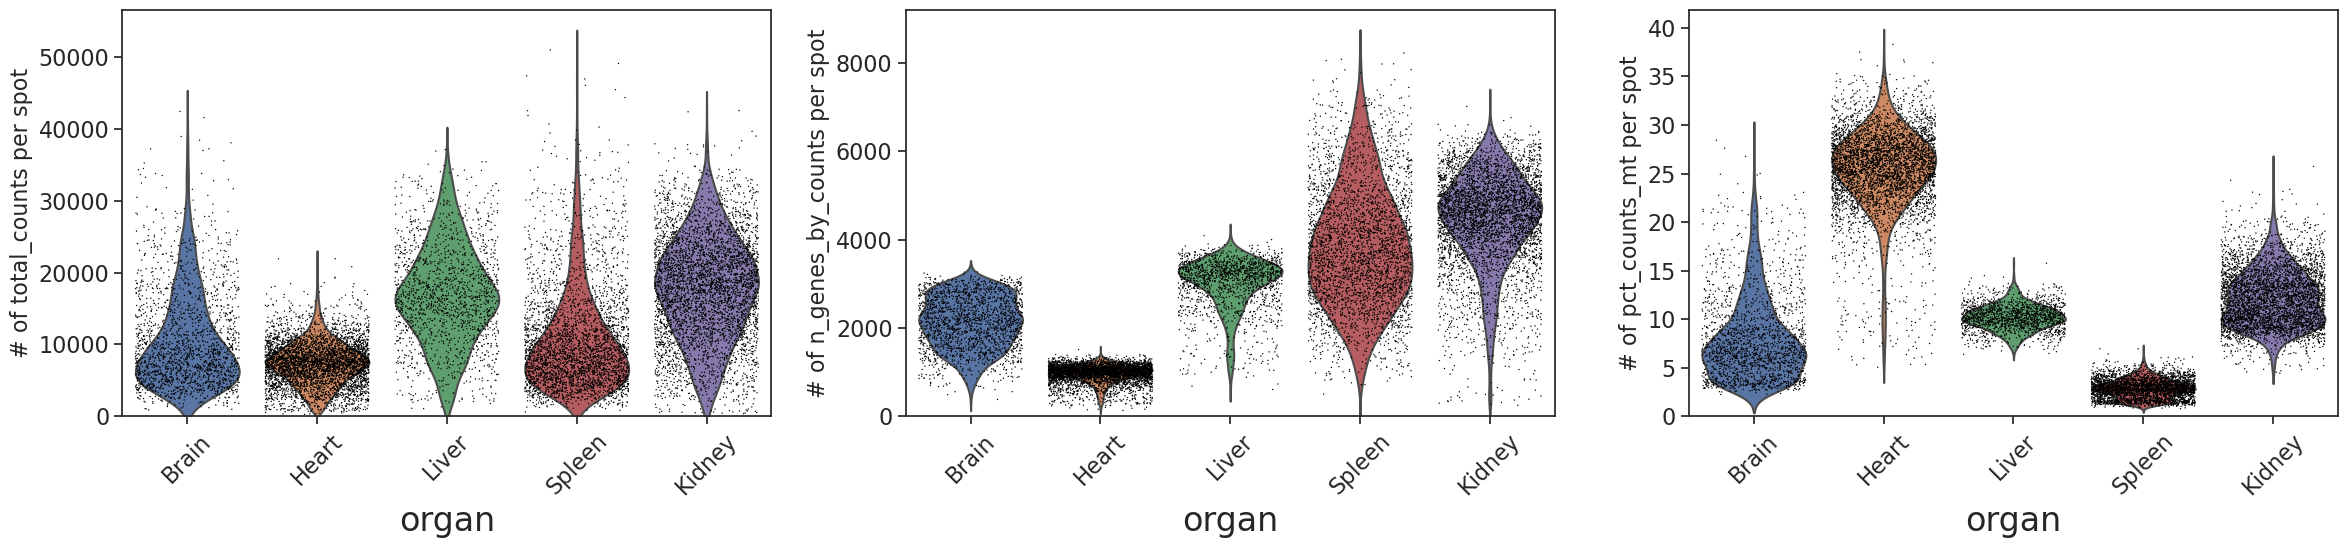

In [60]:
for n, data in datasets.items():
    print(n)
    # set figure
    sns.set_theme(font_scale=2, style='ticks')

    nrows = 1
    ncols = len(cats)
    fig, axs = plt.subplots(nrows, ncols, figsize=(8*ncols, 6*nrows))

    for i, cat in enumerate(cats):
        db.pl.violinplot(data=data, x='organ', y=cat, ax=axs[i], show=False, scale='width', 
                         order=['Brain', 'Heart', 'Liver', 'Spleen', 'Kidney'])
        
    fig.tight_layout()
    
    plt.savefig("figures/clean_dataset/violin_counts_{}.pdf".format(n), bbox_inches="tight")
    plt.show()

# Save data

In [21]:
for organ, adata in perOrgan.items():
    savepath = os.path.join(out_dir, "{}_adata_clean_wohires.h5ad".format(organ))
    print("Save clean {} dataset into: {}".format(organ, savepath))
    adata.write(savepath)

Save clean Heart dataset into: out\Heart_adata_clean_wohires.h5ad
Save clean Liver dataset into: out\Liver_adata_clean_wohires.h5ad
Save clean Kidney dataset into: out\Kidney_adata_clean_wohires.h5ad
Save clean Spleen dataset into: out\Spleen_adata_clean_wohires.h5ad
Save clean Brain dataset into: out\Brain_adata_clean_wohires.h5ad
